In [1]:
%install-location $cwd/swift-install
%install '.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")' Path
%install '.package(url: "https://github.com/sgugger/swiftdata/SwiftCV", .branch("master"))' SwiftCV
%install '.package(url: "https://github.com/sgugger/swiftdata/SwiftData", .branch("master"))' SwiftData

Installing packages:
	.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")
		Path
	.package(url: "https://github.com/sgugger/swiftdata/SwiftCV", .branch("master"))
		SwiftCV
	.package(url: "https://github.com/sgugger/swiftdata/SwiftData", .branch("master"))
		SwiftData
With SwiftPM flags: []
Working in: /tmp/tmp95l0himx/swift-install
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
Fetching https://github.com/sgugger/swiftdata/SwiftCV
error: Failed to clone https://github.com/sgugger/swiftdata/SwiftCV:
    Cloning into bare repository '/home/sgugger/git/swiftdata/nbs/swift-install/package/.build/repositories/SwiftCV-41384c17'...
    remote: Not Found
    fatal: repository 'https://github.com/sgugger/swiftdata/SwiftCV/' not found


: 

In [1]:
%install-location $cwd/swift-install
%install '.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")' Path
%install '.package(path: "$cwd/../SwiftCV")' SwiftCV
%install '.package(path: "$cwd/../SwiftData")' SwiftData
//%install '.package(url: "https://github.com/vvmnnnkv/SwiftCV.git", .branch("master"))' Swif

Installing packages:
	.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")
		Path
	.package(path: "/home/sgugger/git/swiftdata/nbs/../SwiftCV")
		SwiftCV
	.package(path: "/home/sgugger/git/swiftdata/nbs/../SwiftData")
		SwiftData
With SwiftPM flags: []
Working in: /tmp/tmpjtvjd4m9/swift-install
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
/home/sgugger/swift/usr/bin/swiftc: /home/sgugger/anacond

In [ ]:
//%install '.package(url: "https://github.com/vvmnnnkv/SwiftCV.git", .branch("master"))' SwiftCV

In [2]:
import Path
import TensorFlow
import SwiftData

In [3]:
//For image show
import Python
let plt = Python.import("matplotlib.pyplot")

In [4]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


## Data preprocessing pipeline in swift

In [5]:
public protocol BatcherConfig {
    associatedtype Item
    associatedtype Sample
    associatedtype RawBatch
    associatedtype Batch
    
    func processItem(_ item: Item) -> Sample
    func processSamples(_ samples: [Sample]) -> [Sample]
    func collate(_ samples: [Sample]) -> RawBatch 
    func processBatch(_ batch: RawBatch) -> Batch
}

In [13]:
public struct Batcher<C>: Sequence where C: BatcherConfig {
    public let config: C
    public let dataset: [C.Item]
    public var batchSize: Int
    public var numWorkers: Int = 1
    public var shuffle: Bool = false
    public var dropLast: Bool = false
    
    public var count: Int {
        return dataset.count / batchSize + (dataset.count % batchSize == 0 || dropLast ? 0 : 1)
    }
    
    public init(_ config: C, 
                dataset: [C.Item], 
                batchSize: Int, 
                numWorkers: Int = 1, 
                shuffle: Bool = false, 
                dropLast: Bool = false) {
        (self.config, self.dataset, self.batchSize) = (config, dataset, batchSize)
        (self.numWorkers, self.shuffle, self.dropLast) = (numWorkers, shuffle, dropLast)
    }
    
    public func makeIterator() -> BatchIterator<C> {
        return BatchIterator(self)
    }
}

public struct BatchIterator<C>: IteratorProtocol where C: BatcherConfig {
    let b: Batcher<C>
    let indices: [Int]
    var pos: Int = 0
    
    init(_ b: Batcher<C>) { 
        self.b = b
        pos = 0
        indices = b.shuffle ? Array(0..<b.dataset.count) : Array(0..<b.dataset.count).shuffled()
    }
    
    public mutating func next() -> C.Batch? {
        guard pos < b.dataset.count else { return nil }
        let end = min(pos + b.batchSize, b.dataset.count)
        if (end - pos) < b.batchSize && b.dropLast { return nil }
        //The idea is to have samples processed and collated on the CPU before moving to the host, not sure this is the right way.
        let batch = withDevice(.cpu) { () -> C.RawBatch in
            let samples = Array(pos..<end).concurrentMap(nthreads: b.numWorkers) {
                b.config.processItem(b.dataset[indices[$0]])
            }
            pos = end
            return b.config.collate(b.config.processSamples(samples))
        }
        return b.config.processBatch(batch)
    }
}

## Example 1: Imagenette

### Utils

In [5]:
import Foundation
import SwiftCV

In [6]:
let dataPath = Path.home/".fastai"/"data"

Image utils

In [7]:
func openImage(_ fn: Path) -> Mat {
    return imdecode(try! Data(contentsOf: fn.url))
}

In [8]:
func showCVImage(_ img: Mat) {
    let tensImg = Tensor<UInt8>(cvMat: img)!
    let numpyImg = tensImg.makeNumpyArray()
    plt.imshow(numpyImg) 
    plt.axis("off")
    plt.show()
}

With openCV images, the channels are in BGR instead of RGB so we need to siwtch them:

In [9]:
func BGRToRGB(_ img: Mat) -> Mat {
    return cvtColor(img, nil, ColorConversionCode.COLOR_BGR2RGB)
}

In [10]:
func resize(_ img: Mat, size: Int) -> Mat {
    return resize(img, nil, Size(size, size), 0, 0, InterpolationFlag.INTER_LINEAR)
}

In [11]:
func cvImgToTensor(_ img: Mat) -> Tensor<UInt8> {
    return Tensor<UInt8>(cvMat: img)!
}

In [12]:
func showTensorImage<S> (_ img: Tensor<S>) where S: NumpyScalarCompatible {
    let numpyImg = img.makeNumpyArray()
    plt.imshow(numpyImg) 
    plt.axis("off")
    plt.show()
}

### Data collection

In [13]:
let path = dataPath/"imagenette2"/"train"
let fnames = collectFiles(under: path, recurse: true, filtering: ["jpeg", "jpg"])
fnames.count

9469


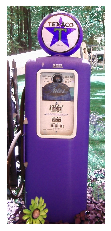

In [14]:
showCVImage(openImage(fnames[0]))

In [15]:
let processImage = openImage >| BGRToRGB >| { resize($0, size: 224) } >| cvImgToTensor

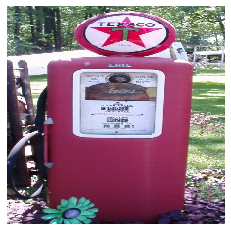

In [16]:
showTensorImage(processImage(fnames[0]))

Labels

In [17]:
let allLabels = fnames.map { $0.parent.basename() }
let labels = Array(Set(allLabels)).sorted()
let labelToInt = Dictionary(uniqueKeysWithValues: labels.enumerated().map{ ($0.element, $0.offset) })
print(labelToInt)

["n03425413": 7, "n03028079": 4, "n03445777": 8, "n03888257": 9, "n02102040": 1, "n03000684": 3, "n02979186": 2, "n01440764": 0, "n03417042": 6, "n03394916": 5]


In [18]:
struct imageConfig: BatcherConfig {
    typealias Item = Path
    typealias Sample = (Tensor<UInt8>, Int)
    typealias RawBatch = (Tensor<UInt8>, Tensor<Int32>)
    typealias Batch = (Tensor<Float>, Tensor<Int32>)
    
    func processItem(_ item: Item) -> Sample {
        return (processImage(item), labelToInt[item.parent.basename()]!)
    }
    
    func processSamples(_ samples: [Sample]) -> [Sample] { return samples }
    
    func collate(_ samples: [Sample]) -> RawBatch {
        return (Tensor(concatenating: samples.map { $0.0.expandingShape(at: 0) }), Tensor(samples.map { Int32($0.1) }))
    }
    
    func processBatch(_ batch: RawBatch) -> Batch {
        return (Tensor<Float>(batch.0) / 255.0, batch.1)
    }
}

In [19]:
let batcher = Batcher(imageConfig(), dataset: fnames, batchSize: 256, numWorkers: 8)

In [20]:
import Dispatch

In [21]:
SetNumThreads(0)

In [22]:
let t = Tensor<Float>(zeros: [1])

In [23]:
let start = DispatchTime.now()
for b in batcher {
    var s = (b.0.shape, b.1.shape)
}
let end = DispatchTime.now()
let nanoseconds = Double(end.uptimeNanoseconds - start.uptimeNanoseconds)
let seconds = nanoseconds / 1e9
print(seconds)

9.980467146


In [28]:
let b = batcher.first(where: {_ in true})!

In [29]:
b.0.shape

▿ [256, 224, 224, 3]
  ▿ dimensions : 4 elements
    - 0 : 256
    - 1 : 224
    - 2 : 224
    - 3 : 3


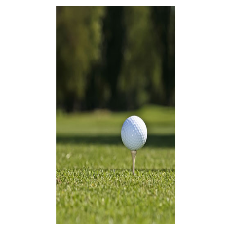

In [30]:
showTensorImage(b.0[0])